In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import datetime as dt
import numpy as np
import pandas as pd
import inspect
import scipy.stats as stats
import datetime as dt
from flask import Flask, jsonify

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [4]:
engine = create_engine("sqlite:///hawaii.sqlite")

# Reflect Tables into SQLAlchemy ORM

In [5]:
# reflect an existing database into a new model
Base=automap_base()
# reflect the tables
Base.prepare(engine,reflect=True)

In [6]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session=Session(engine)

 ## Percipitation Analysis

In [9]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_date_recorded=session.query(func.max(Measurement.date)).all()

today = dt.date.today()

last_date_recorded_datefmt = today.replace(year=int(last_date_recorded[0][0][:4]),\
                                        month=int(last_date_recorded[0][0][5:7]),\
                                        day=int(last_date_recorded[0][0][8:]))
last_date_recorded_datefmt

datetime.date(2017, 8, 23)

In [10]:
start_date_datefmt = last_date_recorded_datefmt-dt.timedelta(days=365)
start_date_datefmt

datetime.date(2016, 8, 23)

In [11]:
last_date_recorded= last_date_recorded_datefmt.strftime("%Y-%m-%d")
start_date_recorded = start_date_datefmt.strftime("%Y-%m-%d")

In [12]:
last_date_md= last_date_recorded_datefmt.strftime("%m-%d")
last_date_md

'08-23'

In [13]:
# Perform a query to retrieve the data and precipitation scores
percip_data=session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date>start_date_recorded).\
    filter(Measurement.date<=last_date_recorded).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
percip_df=pd.DataFrame(percip_data,columns=['date','percipitation'])
percip_df.set_index('date', inplace=True)
percip_df.head()                                          

,percipitation
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


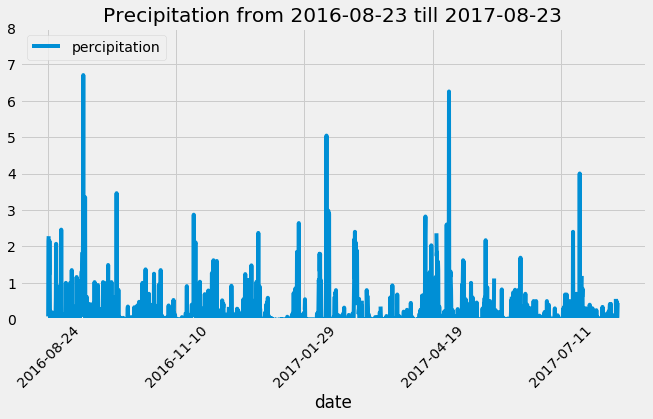

In [14]:
percip_df.plot(figsize=(10,5),ylim=(0,8),title=f'Precipitation from {start_date_recorded} till {last_date_recorded}',\
                  label="Precipitation",rot=45)
plt.legend(loc="upper left")
plt.savefig("Images/Precipitation_Analysis.jpg")
plt.show()

In [15]:
#Use Pandas to print the summary statistics for the percipitation data
percip_df.describe()

,percipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


 ## Station Analysis

In [16]:
data_1year=session.query(Measurement.station,Measurement.date, Measurement.prcp,Measurement.tobs).\
    filter(Measurement.date>'2016-08-23').\
    filter(Measurement.date<='2017-08-23').\
    order_by(Measurement.date).all()
data_1year_df=pd.DataFrame(data_1year, columns=['station','date','prcp','tobs'])
data_1year_df.set_index('date', inplace=True)
data_1year_df['station'].value_counts()

USC00519397    360
USC00519281    351
USC00516128    348
USC00513117    342
USC00519523    336
USC00514830    304
USC00517948    182
Name: station, dtype: int64

In [17]:
# Design a query to show how many stations are available in this dataset?
data=session.query(Measurement.station,Measurement.date, Measurement.prcp,Measurement.tobs).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
data_df=pd.DataFrame(data, columns=['station','date','prcp','tobs'])
data_df.set_index('date', inplace=True)

In [18]:
station_count=len(data_df['station'].unique())
print(f'There are {station_count} stations')

There are 9 stations


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
data_df['station'].value_counts()

USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
Name: station, dtype: int64

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station_df = data_df.loc[data_df['station']=='USC00519281']
temp_max = most_active_station_df['tobs'].max()
print(f'The max recorded temperature at USC00519281 between {start_date_recorded} and {last_date_recorded} was {temp_max}')
temp_min = (most_active_station_df['tobs'].min())
print(f'The min recorded temperature at USC00519281 between {start_date_recorded} and {last_date_recorded} was {temp_min}')
temp_avg = round((most_active_station_df['tobs'].mean()),1)
print(f'The average recorded temperature at USC00519281 between {start_date_recorded} and {last_date_recorded} was {temp_avg}')

The max recorded temperature at USC00519281 between 2016-08-23 and 2017-08-23 was 85.0
The min recorded temperature at USC00519281 between 2016-08-23 and 2017-08-23 was 54.0
The average recorded temperature at USC00519281 between 2016-08-23 and 2017-08-23 was 71.7


In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data=session.query(Measurement.date,Measurement.station,Measurement.tobs).\
    filter(Measurement.station =='USC00519281').\
    filter(Measurement.date>'2016-08-23').\
    filter(Measurement.date<='2017-08-23').all()

# # Save the query results as a Pandas DataFrame and set the index to the date column
# temp_df=temp_data.DataFrame(temp_data, columns=['tobs'])
temp_data_df = pd.DataFrame(temp_data,columns=['date','station_id','temperatures'])
temp_data_df.head()

,date,station_id,temperatures
0,2016-08-24,USC00519281,77.0
1,2016-08-25,USC00519281,80.0
2,2016-08-26,USC00519281,80.0
3,2016-08-27,USC00519281,75.0
4,2016-08-28,USC00519281,73.0


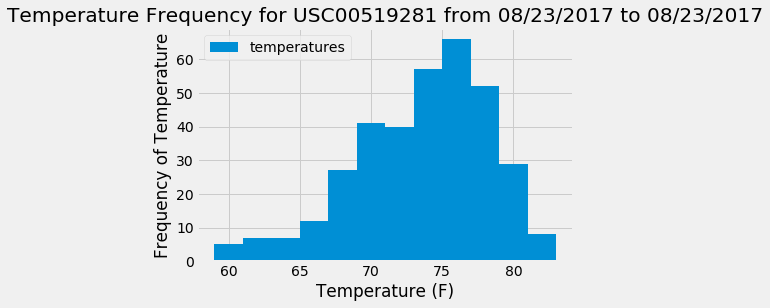

In [22]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_data_df.plot.hist(by="tobs",bins=12,label="tobs",title=f'Temperature Frequency for USC00519281 from 08/23/2017 to 08/23/2017')
plt.ylim=(0,80)
plt.ylabel("Frequency of Temperature")
plt.xlabel("Temperature (F)")
plt.legend=()
plt.savefig("Images/Temperature_Analysis.jpg")
plt.show()

## Step 2 - Climate App

### Getting Last Date from Data Set

In [ ]:
def date_calc():

    latest_date = session.query(func.max(Measurement.date)).all()

    session.close
   
    today = dt.date.today()
    lastest_date_datefmt = today.replace(year=int(latest_date[0][0][:4]),\
                                        month=int(latest_date[0][0][5:7]),\
                                        day=int(latest_date[0][0][8:]))
    
    one_year_backdate = lastest_date_datefmt-dt.timedelta(days=365)
    
    data_end_date_ymd = lastest_date_datefmt.strftime("%Y-%m-%d")
    start_date_ymd = one_year_backdate.strftime("%Y-%m-%d")
    
    Year_list = [start_date_ymd,data_end_date_ymd]
    return(tuple(Year_list))

app = Flask(__name__)

### Website Landing Page

In [ ]:
@app.route("/")
def home():
    print("Server received request for 'Home' page")
    return f"""Available Routes:<br/>
        <br/>
        /api/v1.0/precipitation<br/>
        <br/>
        /api/v1.0/stations<br/>
        <br/>
        /api/v1.0/tobs<br/>
        <br/>
        /api/v1.0/start<br/>
        <br/>
        /api/v1.0/start/end<br/>
        <br/>
        Note:
        Latest available date is 2017-08-23
        start and end dates must be in 'YYYY-MM-DD' format"""

### Precipitation Page

In [ ]:
@app.route("/api/v1.0/precipitation")
def percipitation():
    print("Server received request for 'Precipitation' page")

    range = date_calc()
    end_date = range[1]
    start_date = range[0]
        
    results = session.query(Measurement.date, Measurement.station, Measurement.prcp).\
        filter(Measurement.date <= end_date).\
        filter(Measurement.date >= start_date).all()
        
    session.close
         
    all_percipitation = []
    for result in results:
        percipitation_dict = {"Date":result[0], "Station":result[1],"Precipitation":result[2]}
        all_percipitation.append(percipitation_dict)
    
    return jsonify(all_percipitation)

### Stations Page

In [ ]:
@app.route("/api/v1.0/stations")
def stations():
    print("Server received request for 'Station' page")
        
    results = session.query(Station.station, Station.name).all()
        
    session.close

    all_stations = []
    for result in results:
        stations_dict = {"Station ID:":results[0],"Station Name":results[1]}
        all_stations.append(stations_dict)
    
    return jsonify(all_stations)

### Temperatures Page

In [ ]:
@app.route("/api/v1.0/tobs")
def tobs():
    print("Server received request for 'TOBS' page")

    Range = date_calc()
    End_date = Range[1]
    Start_date = Range[0]
        
    results = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
        filter(Measurement.date <= End_date).\
        filter(Measurement.date >= Start_date).\
        filter(Measurement.station == 'USC00519397').all()
        
    session.close

    all_tobs = []
    for temp in results:
        stations_dict = {"Date": temp[0], "Temperature": temp[1]}
        all_tobs.append(stations_dict)
    
    return jsonify(all_tobs)

### Temperature Min/Avg/Max from Start Date to End of Data

In [ ]:
@app.route("/api/v1.0/<start>")
def timestart(start):
        
    print("Server received request for 'Starting Weather Date' page")
        
    results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start).all()

    session.close
    
    results_dict = {"Minimum Temp":results[0][0],"Average Temp":results[0][1], "Maximum Temp":results[0][2]}

    return jsonify(results_dict)

### Temperature Min/Avg/Max from Start to End Dates

In [ ]:
@app.route("/api/v1.0/<start>/<end>")
def timestartend(start,end):
    print("Server received request for 'Weather Date Range' page")

    results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start).filter(Measurement.date <= end).all()

    session.close
    
    results_dict = {"Minimum Temp":results[0][0],"Average Temp":results[0][1], "Maximum Temp":results[0][2]}

    return jsonify(results_dict)

if __name__ == '__main__':
    app.run(debug=True)

## Bonus Challenge Assignment

### Temperature Analysis I

In [23]:
# June Average Temperature for at all stations across all available year in the dataset.
june_avg_temp = session.query(func.avg(Measurement.tobs)).\
                filter(func.strftime("%m",Measurement.date) == "06").all()
june_avg_temp


[(74.94411764705882)]

In [24]:
# December Average Temperature for at all stations across all available year in the dataset.
dec_avg_temp = session.query(func.avg(Measurement.tobs)).\
                filter(func.strftime("%m",Measurement.date) == "12").all()
dec_avg_temp

[(71.04152933421226)]

In [25]:
# Independent ttest because the temperatures in June are independent from the temperatures in December
# The p-value is incredibly small (much less than .05) so the difference in their average temperature is significant 
june_temp_data=session.query(Measurement.tobs).\
    filter(func.strftime("%m",Measurement.date) == "06").all()
dec_temp_data=session.query(Measurement.tobs).\
    filter(func.strftime("%m",Measurement.date) == "12").all()
stats.ttest_ind(june_temp_data,dec_temp_data, equal_var=False)

Ttest_indResult(statistic=array([31.35503692]), pvalue=array([4.19352984e-187]))

### Temperature Analysis II

In [26]:
# Calculate previous year's date based on the current trip start & end dates
start_date = input("Enter the trip start date in 'YYYY-MM-DD' format: ")
end_date = input("Enter the trip end date in 'YYYY-MM-DD' format: ")

Enter the trip start date in 'YYYY-MM-DD' format: 2020-09-05
Enter the trip end date in 'YYYY-MM-DD' format: 2020-09-15


In [27]:
# Calculate the previous year's dates based on the input dates
# note:because data is dated, went back 4 years for comparable period
Struct = dt.date.today()
start_date_format = Struct.replace(year=int(start_date[:4]),month=int(start_date[5:7]),day=int(start_date[8:]))
prior_period_start_date = start_date_format - dt.timedelta(days=365*4+1)
prior_period_start_date = prior_period_start_date.strftime("%Y-%m-%d")

end_date_format = Struct.replace(year=int(end_date[:4]),month=int(end_date[5:7]),day=int(end_date[8:]))
prior_period_end_date = end_date_format - dt.timedelta(days=365*4+1)
prior_period_end_date = prior_period_end_date.strftime("%Y-%m-%d")


# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):

    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# Because data is dated, prior same period is four years back
result = calc_temps(prior_period_start_date, prior_period_end_date)
print(result)

[(71.0, 77.22857142857143, 84.0)]


In [28]:
prior_period_start_date = start_date_format - dt.timedelta(days=365*4+1)
prior_period_start_date = prior_period_start_date.strftime("%m-%d")
prior_period_start_date

'09-05'

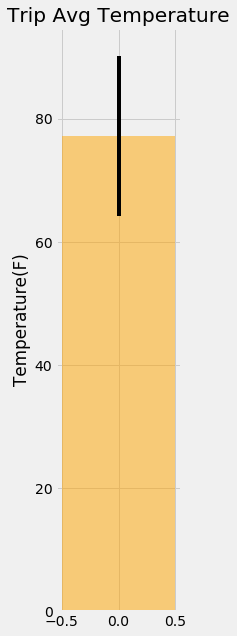

In [29]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmin = result[0][0]
tavg = result[0][1]
tmax = result[0][2]
y_err = tmax-tmin

plt.figure(figsize=(2,10))
plt.bar(0,tavg,yerr=y_err,align="center",width=1,color="orange",alpha=0.5)
plt.ylim=(0,120)
plt.ylabel("Temperature(F)")
plt.title("Trip Avg Temperature")
plt.savefig("Images/Trip_Avg_Temp_Analysis.jpg")
plt.show()